In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as svm
import seaborn as sb

Necessary Data Imports for Question 3:

In [2]:
train_features = pd.read_csv('question3/q3_train_features.csv', header = None).loc[:, 1:43]
test_features = pd.read_csv('question3/q3_test_features.csv', header = None).loc[:, 1:43].to_numpy()
train_binary_labels = pd.read_csv('question3/q3_train_binary_labels.csv', header = None)[1].to_numpy()
test_binary_labels = pd.read_csv('question3/q3_test_binary_labels.csv', header = None)[1].to_numpy()
train_multiclass_labels = pd.read_csv('question3/q3_train_multiclass_labels.csv', header = None)[1].to_numpy()
test_multiclass_labels = pd.read_csv('question3/q3_test_multiclass_labels.csv', header = None)[1].to_numpy()

"train_linear_binary_SVM" returns a trained linear SVM model based on a c value given as an input (binary model)

In [41]:
def train_linear_binary_SVM(train_feature_set, train_labels, c_value):
    model = svm.LinearSVC(C = c_value, max_iter = 2000000, random_state = 0)
    model.fit(train_feature_set, train_labels)
    return model

In [28]:
def evaluate_metrics(valid_set, valid_labels, model):
    predictions = model.predict(valid_set)
    tp, fp, fn, tn = 0, 0, 0, 0
    for idx in range(predictions.size):
        if valid_labels[idx] == 1:
            if valid_labels[idx] == predictions[idx]:
                tp += 1
            else:
                fn += 1
        else:
            if valid_labels[idx] == predictions[idx]:
                tn += 1
            else:
                fp += 1
    if tp + fp + tn + fn == 0:
        accuracy = 0
    else:
        accuracy = (tp + tn) / (tp + fp + tn + fn)
    if tp + fp == 0:
        precision = 0
        fdr = 0
    else:
        precision = tp / (tp + fp)
        fdr = fp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if tn + fn == 0:
        npv = 0
    else:
        npv = tn / (tn + fn)
    if fp + tn == 0:
        fpr = 0
    else:
        fpr = fp / (fp + tn)
    if precision +  recall == 0:
        f1 = 0
        f2 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
        f2 = (5 * precision * recall) / (4 * precision + recall)
    return [[tp, fp, fn, tn], accuracy, precision, recall, npv, fpr, fdr, f1, f2]

In [32]:
def evaluate_linear_binary_SVM(train_feature_set, train_label_set, c):
    folds = []
    label_folds = []
    run_features = []
    run_labels = []
    models = []
    idx = 0
    metrics = []
    for fold_no in range(5):
        folds.append(np.array(train_feature_set[idx:(idx + (train_feature_set.shape[0] // 5))]))
        label_folds.append(np.array(train_label_set[idx:(idx + (train_label_set.shape[0] // 5))]))
        run_features.append(np.concatenate((train_feature_set[0:idx], train_feature_set[idx + (train_feature_set.shape[0] // 5):])))
        run_labels.append(np.concatenate((train_label_set[0:idx], train_label_set[idx + (train_label_set.shape[0] // 5):])))
        models.append(train_linear_binary_SVM(run_features[fold_no], run_labels[fold_no], c))
        metrics.append(evaluate_metrics(folds[fold_no], label_folds[fold_no], models[fold_no]))
        idx += (train_feature_set.shape[0] // 5)
    return metrics

In [178]:
def analyze_metric_values(metric_set):
    accuracy_sum = 0
    precision_sum = 0
    recall_sum = 0
    npv_sum = 0
    fpr_sum = 0
    fdr_sum = 0
    f1_sum = 0
    f2_sum = 0
    matrix = np.zeros(4)
    for metrics in metric_set:
        accuracy_sum += metrics[1]
        precision_sum += metrics[2]
        recall_sum += metrics[3]
        npv_sum += metrics[4]
        fpr_sum += metrics[5]
        fdr_sum += metrics[6]
        f1_sum += metrics[7]
        f2_sum += metrics[8]
        matrix = np.add(matrix, metrics[0])
    # Average accuracy
    accuracy = accuracy_sum / 5
    print('Accuracy: ' + str(accuracy))
    # Precision
    print('Macro Precision: ' + str(precision_sum / 5))
    if matrix[0] + matrix[1] == 0:
        print('Micro Precision: ' + str(0))
    else:
        print('Micro Precision: ' + str(matrix[0] / (matrix[0] + matrix[1])))
    # Recall
    print('Macro Recall: ' + str(recall_sum / 5))
    if matrix[0] + matrix[2] == 0:
        print('Micro Recall: ' + str(0))
    else:
        print('Micro Recall: ' + str(matrix[0] / (matrix[0] + matrix[2])))
    # NPV
    print('Macro NPV: ' + str(npv_sum / 5))
    if matrix[2] + matrix[3] == 0:
        print('Micro NPV: ' + str(0))
    else:
        print('Micro NPV: ' + str(matrix[3] / (matrix[2] + matrix[3])))
    # FPR
    print('Macro FPR: ' + str(fpr_sum / 5))
    if matrix[1] + matrix[3] == 0:
        print('Micro FPR: ' + str(0))
    else:
        print('Micro FPR: ' + str(matrix[1] / (matrix[1] + matrix[3])))
    # FDR
    print('Macro FDR: ' + str(fdr_sum / 5))
    if matrix[0] + matrix[1] == 0:
        print('Micro FDR: ' + str(0))
    else:
        print('Micro FDR: ' + str(matrix[1] / (matrix[0] + matrix[1])))
    # F-Measures (for beta = 1 and beta = 2)
    print('F1 Measure Value: ' + str(f1_sum / 5))
    print('F2 Measure Value: ' + str(f2_sum / 5))
    confusion_matrix = pd.DataFrame([[matrix[0], matrix[1]], [matrix[2], matrix[3]]], 
                                    columns = ['1', '0'], index = ['1', '0'])
    sb.heatmap(confusion_matrix, annot = True)
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.show()
    return [accuracy, recall_sum / 5, fpr_sum / 5]

In [179]:
def tune_linear_SVM(train_feature_set, train_label_set):
    c_set = (10**(-3), 10**(-2), 10**(-1), 1, 10**(1), 10**(2))
    acc_values = []
    recall_values = []
    fpr_values = []
    for c in c_set:
        print('For C = ' + str(c))
        metrics = evaluate_linear_binary_SVM(train_feature_set, train_label_set, c)
        acc_roc = analyze_metric_values(metrics)
        acc_values.append(acc_roc[0])
        recall_values.append(acc_roc[1])
        fpr_values.append(acc_roc[2])
    return [acc_values, recall_values, fpr_values]

In [180]:
def plot_results(results, param_name, param_set):
    plt.bar(param_set, results)
    plt.xlabel(param_name + ' values')
    plt.ylabel('Accuracy Values')
    plt.title('Accuracy vs ' + param_name + ' values obtained by 5-fold cross validation')
    plt.show()
    plt.clf()

In [201]:
def test_linear_binary_model(train_feature_set, train_label_set, test_feature_set, test_label_set):
    results = tune_linear_SVM(train_feature_set, train_label_set)
    print(results)
    plot_results(results[0], 'C', ('0.001', '0.01', '0.1', '1', '10', '100'))
    c_set = (10**(-3), 10**(-2), 10**(-1), 1, 10, 100)
    acc_auc_c = []
    for idx in range(len(c_set)):
        acc_auc_c.append((c_set[idx], results[1][idx] + results[2][idx], results[0][idx]))
    acc_auc_c.sort(key=lambda tup: tup[1])
    print(acc_auc_c)
    print('Optimum C value: ' + str(acc_auc_c[len(acc_auc_c) - 1][0]), ', respective accuracy: ' + str(acc_auc_c[len(acc_auc_c) - 1][2]))
    print('Slope of ROC curve for optimum c value: ' + str(acc_auc_c[len(acc_auc_c) - 1][1]))
    model = train_linear_binary_SVM(train_feature_set, train_label_set, acc_auc_c[len(acc_auc_c) - 1][0])
    metrics = evaluate_metrics(test_feature_set, test_label_set, model)
    print('For the final model: ')
    print('Accuracy: ' + str(metrics[1]))
    print('Precision: ' + str(metrics[2]))
    print('Recall: ' + str(metrics[3]))
    print('NPV: ' + str(metrics[4]))
    print('FPR: ' + str(metrics[5]))
    print('FDR: ' + str(metrics[6]))
    print('F1-Measure: ' + str(metrics[7]))
    print('F2-Measure: ' + str(metrics[8]))
    confusion_matrix = pd.DataFrame([[metrics[0][0], metrics[0][1]], [metrics[0][2], metrics[0][3]]], 
                                    columns = ['1', '0'], index = ['1', '0'])
    sb.heatmap(confusion_matrix, annot = True)
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Confusion Matrix for C value ' + str(acc_auc_c[len(acc_auc_c) - 1][0]))
    plt.show()

For C = 0.001
Accuracy: 0.825
Macro Precision: 0.0
Micro Precision: 0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.825
Micro NPV: 0.825
Macro FPR: 0.0
Micro FPR: 0.0
Macro FDR: 0.0
Micro FDR: 0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


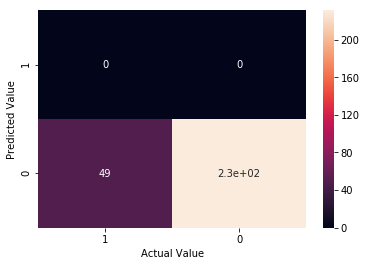

For C = 0.01
Accuracy: 0.825
Macro Precision: 0.0
Micro Precision: 0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.825
Micro NPV: 0.825
Macro FPR: 0.0
Micro FPR: 0.0
Macro FDR: 0.0
Micro FDR: 0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


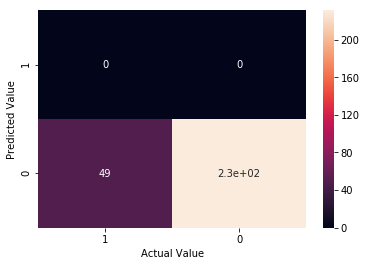

For C = 0.1
Accuracy: 0.8142857142857143
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.8232900432900433
Micro NPV: 0.8231046931407943
Macro FPR: 0.012677304964539008
Micro FPR: 0.012987012987012988
Macro FDR: 0.4
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


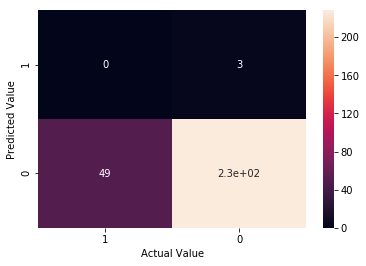

For C = 1
Accuracy: 0.7928571428571429
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.8193697043697042
Micro NPV: 0.8191881918819188
Macro FPR: 0.03862715298885512
Micro FPR: 0.03896103896103896
Macro FDR: 0.8
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


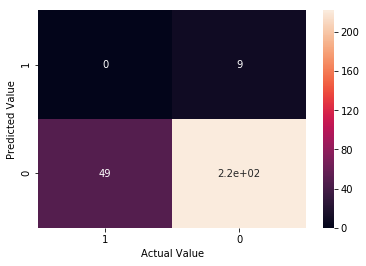

For C = 10
Accuracy: 0.7892857142857144
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.818810654754051
Micro NPV: 0.8185185185185185
Macro FPR: 0.04279381965552178
Micro FPR: 0.04329004329004329
Macro FDR: 0.8
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


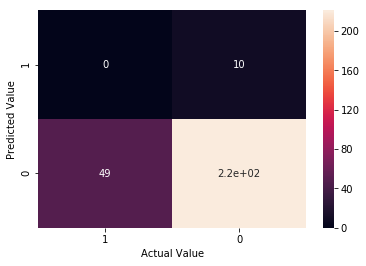

For C = 100


/Users/yusufdalva/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/yusufdalva/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/yusufdalva/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/yusufdalva/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.7892857142857144
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.818810654754051
Micro NPV: 0.8185185185185185
Macro FPR: 0.04279381965552178
Micro FPR: 0.04329004329004329
Macro FDR: 0.8
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


/Users/yusufdalva/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


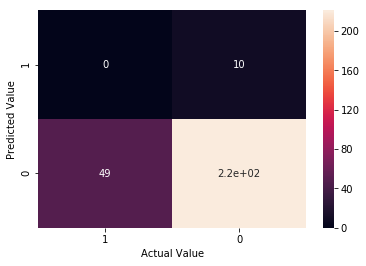

[[0.825, 0.825, 0.8142857142857143, 0.7928571428571429, 0.7892857142857144, 0.7892857142857144], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.012677304964539008, 0.03862715298885512, 0.04279381965552178, 0.04279381965552178]]


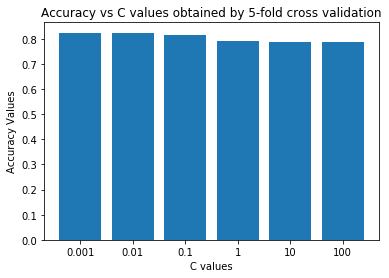

[(0.001, 0.0, 0.825), (0.01, 0.0, 0.825), (0.1, 0.012677304964539008, 0.8142857142857143), (1, 0.03862715298885512, 0.7928571428571429), (10, 0.04279381965552178, 0.7892857142857144), (100, 0.04279381965552178, 0.7892857142857144)]
Optimum C value: 100 , respective accuracy: 0.7892857142857144
Slope of ROC curve for optimum c value: 0.04279381965552178
For the final model: 
Accuracy: 0.8260869565217391
Precision: 0.5
Recall: 0.1
NPV: 0.8378378378378378
FPR: 0.021052631578947368
FDR: 0.5
F1-Measure: 0.16666666666666669
F2-Measure: 0.11904761904761904


/Users/yusufdalva/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


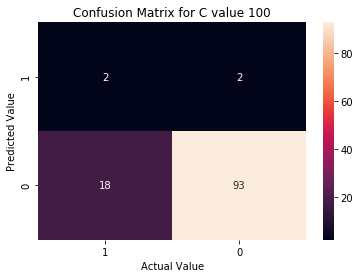

In [202]:
test_linear_binary_model(train_features, train_binary_labels, test_features, test_binary_labels)

In [135]:
def train_RBF_binary_SVM(train_feature_set, train_label_set, gamma):
    model = svm.SVC(kernel = 'rbf', gamma = gamma, max_iter = 2000000, C = 100, random_state = 0)
    model.fit(train_feature_set, train_label_set)
    return model

In [54]:
def evaluate_RBF_binary_SVM(train_feature_set, train_label_set, gamma):
    folds = []
    label_folds = []
    run_features = []
    run_labels = []
    models = []
    idx = 0
    metrics = []
    for fold_no in range(5):
        folds.append(np.array(train_feature_set[idx:(idx + (train_feature_set.shape[0] // 5))]))
        label_folds.append(np.array(train_label_set[idx:(idx + (train_label_set.shape[0] // 5))]))
        run_features.append(np.concatenate((train_feature_set[0:idx], train_feature_set[idx + (train_feature_set.shape[0] // 5):])))
        run_labels.append(np.concatenate((train_label_set[0:idx], train_label_set[idx + (train_label_set.shape[0] // 5):])))
        models.append(train_RBF_binary_SVM(run_features[fold_no], run_labels[fold_no], gamma))
        metrics.append(evaluate_metrics(folds[fold_no], label_folds[fold_no], models[fold_no]))
        idx += (train_feature_set.shape[0] // 5)
    return metrics

In [184]:
def tune_RBF_SVM(train_feature_set, train_label_set):
    gamma_set = (2**(-4), 2**(-3), 2**(-2), 2**(-1), 1, 2)
    acc_rbf_values = []
    recall_rbf_values = []
    fpr_rbf_values = []
    for gamma in gamma_set:
        print('For Gamma = ' + str(gamma))
        metrics = evaluate_RBF_binary_SVM(train_feature_set, train_label_set, gamma)
        acc_roc = analyze_metric_values(metrics)
        acc_rbf_values.append(acc_roc[0])
        recall_rbf_values.append(acc_roc[1])
        fpr_rbf_values.append(acc_roc[2])
    return [acc_rbf_values, recall_rbf_values, fpr_rbf_values]

For Gamma = 0.0625
Accuracy: 0.7821428571428573
Macro Precision: 0.04
Micro Precision: 0.07142857142857142
Macro Recall: 0.025
Micro Recall: 0.02040816326530612
Macro NPV: 0.8205909776498013
Micro NPV: 0.8195488721804511
Macro FPR: 0.054964539007092195
Micro FPR: 0.05627705627705628
Macro FDR: 0.76
Micro FDR: 0.9285714285714286
F1 Measure Value: 0.03076923076923077
F2 Measure Value: 0.02702702702702702


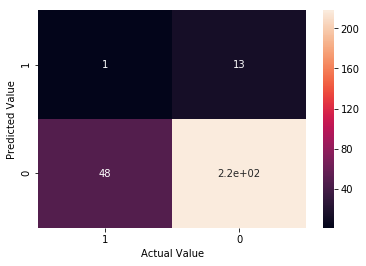

For Gamma = 0.125
Accuracy: 0.8214285714285715
Macro Precision: 0.1
Micro Precision: 0.3333333333333333
Macro Recall: 0.025
Micro Recall: 0.02040816326530612
Macro NPV: 0.827061087061087
Micro NPV: 0.8267148014440433
Macro FPR: 0.008421985815602837
Micro FPR: 0.008658008658008658
Macro FDR: 0.3
Micro FDR: 0.6666666666666666
F1 Measure Value: 0.04
F2 Measure Value: 0.029411764705882353


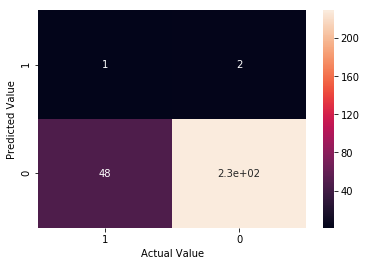

For Gamma = 0.25
Accuracy: 0.8214285714285715
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.8244155844155845
Micro NPV: 0.8243727598566308
Macro FPR: 0.00425531914893617
Micro FPR: 0.004329004329004329
Macro FDR: 0.2
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


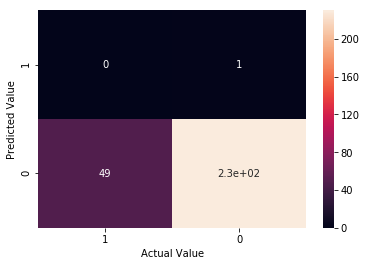

For Gamma = 0.5
Accuracy: 0.8214285714285715
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.8244155844155845
Micro NPV: 0.8243727598566308
Macro FPR: 0.00425531914893617
Micro FPR: 0.004329004329004329
Macro FDR: 0.2
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


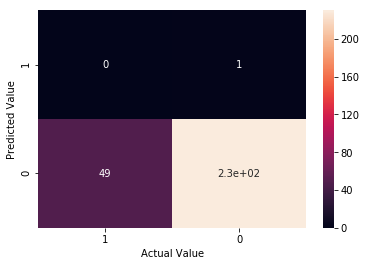

For Gamma = 1
Accuracy: 0.825
Macro Precision: 0.0
Micro Precision: 0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.825
Micro NPV: 0.825
Macro FPR: 0.0
Micro FPR: 0.0
Macro FDR: 0.0
Micro FDR: 0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


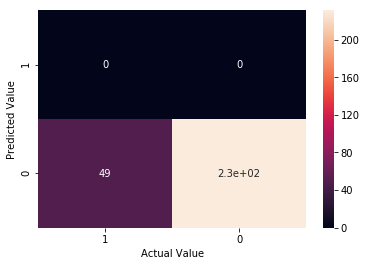

For Gamma = 2
Accuracy: 0.825
Macro Precision: 0.0
Micro Precision: 0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.825
Micro NPV: 0.825
Macro FPR: 0.0
Micro FPR: 0.0
Macro FDR: 0.0
Micro FDR: 0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


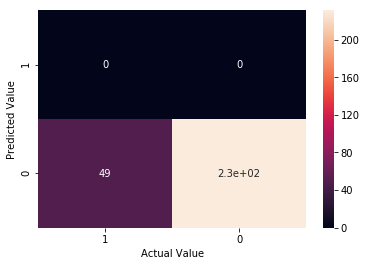

[[0.7821428571428573,
  0.8214285714285715,
  0.8214285714285715,
  0.8214285714285715,
  0.825,
  0.825],
 [0.025, 0.025, 0.0, 0.0, 0.0, 0.0],
 [0.054964539007092195,
  0.008421985815602837,
  0.00425531914893617,
  0.00425531914893617,
  0.0,
  0.0]]

In [185]:
tune_RBF_SVM(train_features, train_binary_labels)

In [203]:
def test_RBF_binary_model(train_feature_set, train_label_set, test_feature_set, test_label_set):
    results = tune_RBF_SVM(train_feature_set, train_label_set)
    print(results)
    plot_results(results[0], 'Gamma', ('0.0625', '0.125', '0.25', '0.5', '1', '2'))
    gamma_set = (2**(-4), 2**(-3), 2**(-2), 2**(-1), 1, 2)
    acc_auc_gamma = []
    for idx in range(len(gamma_set)):
        acc_auc_gamma.append((gamma_set[idx], results[1][idx] + results[2][idx], results[0][idx]))
    acc_auc_gamma.sort(key=lambda tup: tup[1])
    print(acc_auc_gamma)
    print('Optimum Gamma value: ' + str(acc_auc_gamma[len(acc_auc_gamma) - 1][0]), ', respective accuracy: ' + str(acc_auc_gamma[len(acc_auc_gamma) - 1][2]))
    print('F1 Measure for optimal Gamma value: ' + str(acc_auc_gamma[len(acc_auc_gamma) - 1][1]))
    model = train_RBF_binary_SVM(train_feature_set, train_label_set, acc_auc_gamma[len(acc_auc_gamma) - 1][0])
    metrics = evaluate_metrics(test_feature_set, test_label_set, model)
    print('For the final model: ')
    print('Accuracy: ' + str(metrics[1]))
    print('Precision: ' + str(metrics[2]))
    print('Recall: ' + str(metrics[3]))
    print('NPV: ' + str(metrics[4]))
    print('FPR: ' + str(metrics[5]))
    print('FDR: ' + str(metrics[6]))
    print('F1-Measure: ' + str(metrics[7]))
    print('F2-Measure: ' + str(metrics[8]))
    confusion_matrix = pd.DataFrame([[metrics[0][0], metrics[0][1]], [metrics[0][2], metrics[0][3]]], 
                                    columns = ['1', '0'], index = ['1', '0'])
    sb.heatmap(confusion_matrix, annot = True)
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Confusion Matrix for Gamma value ' + str(acc_auc_gamma[len(acc_auc_gamma) - 1][0]))
    plt.show()
    return acc_auc_gamma[len(acc_auc_gamma) - 1][0]

For Gamma = 0.0625
Accuracy: 0.7821428571428573
Macro Precision: 0.04
Micro Precision: 0.07142857142857142
Macro Recall: 0.025
Micro Recall: 0.02040816326530612
Macro NPV: 0.8205909776498013
Micro NPV: 0.8195488721804511
Macro FPR: 0.054964539007092195
Micro FPR: 0.05627705627705628
Macro FDR: 0.76
Micro FDR: 0.9285714285714286
F1 Measure Value: 0.03076923076923077
F2 Measure Value: 0.02702702702702702


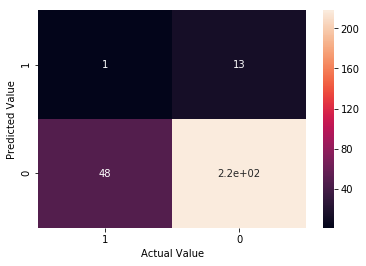

For Gamma = 0.125
Accuracy: 0.8214285714285715
Macro Precision: 0.1
Micro Precision: 0.3333333333333333
Macro Recall: 0.025
Micro Recall: 0.02040816326530612
Macro NPV: 0.827061087061087
Micro NPV: 0.8267148014440433
Macro FPR: 0.008421985815602837
Micro FPR: 0.008658008658008658
Macro FDR: 0.3
Micro FDR: 0.6666666666666666
F1 Measure Value: 0.04
F2 Measure Value: 0.029411764705882353


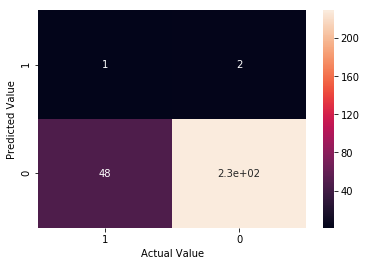

For Gamma = 0.25
Accuracy: 0.8214285714285715
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.8244155844155845
Micro NPV: 0.8243727598566308
Macro FPR: 0.00425531914893617
Micro FPR: 0.004329004329004329
Macro FDR: 0.2
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


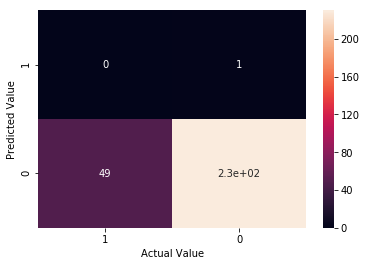

For Gamma = 0.5
Accuracy: 0.8214285714285715
Macro Precision: 0.0
Micro Precision: 0.0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.8244155844155845
Micro NPV: 0.8243727598566308
Macro FPR: 0.00425531914893617
Micro FPR: 0.004329004329004329
Macro FDR: 0.2
Micro FDR: 1.0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


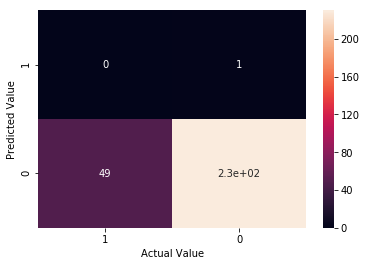

For Gamma = 1
Accuracy: 0.825
Macro Precision: 0.0
Micro Precision: 0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.825
Micro NPV: 0.825
Macro FPR: 0.0
Micro FPR: 0.0
Macro FDR: 0.0
Micro FDR: 0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


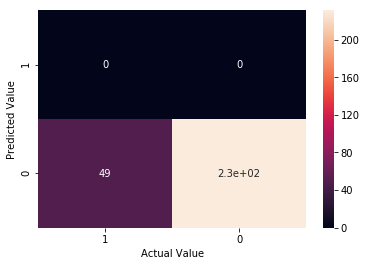

For Gamma = 2
Accuracy: 0.825
Macro Precision: 0.0
Micro Precision: 0
Macro Recall: 0.0
Micro Recall: 0.0
Macro NPV: 0.825
Micro NPV: 0.825
Macro FPR: 0.0
Micro FPR: 0.0
Macro FDR: 0.0
Micro FDR: 0
F1 Measure Value: 0.0
F2 Measure Value: 0.0


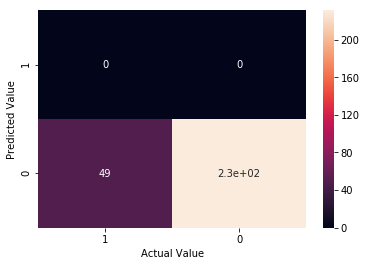

[[0.7821428571428573, 0.8214285714285715, 0.8214285714285715, 0.8214285714285715, 0.825, 0.825], [0.025, 0.025, 0.0, 0.0, 0.0, 0.0], [0.054964539007092195, 0.008421985815602837, 0.00425531914893617, 0.00425531914893617, 0.0, 0.0]]


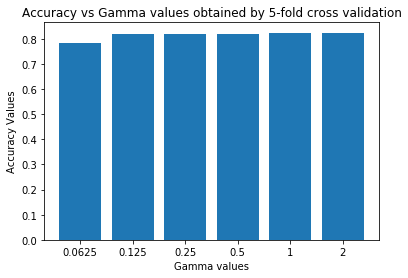

[(1, 0.0, 0.825), (2, 0.0, 0.825), (0.25, 0.00425531914893617, 0.8214285714285715), (0.5, 0.00425531914893617, 0.8214285714285715), (0.125, 0.03342198581560284, 0.8214285714285715), (0.0625, 0.07996453900709219, 0.7821428571428573)]
Optimum Gamma value: 0.0625 , respective accuracy: 0.7821428571428573
F1 Measure for optimal Gamma value: 0.07996453900709219
For the final model: 
Accuracy: 0.8347826086956521
Precision: 1.0
Recall: 0.05
NPV: 0.8333333333333334
FPR: 0.0
FDR: 0.0
F1-Measure: 0.09523809523809523
F2-Measure: 0.0617283950617284


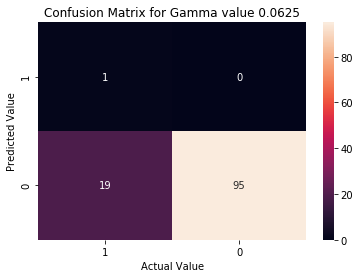

0.0625

In [204]:
test_RBF_binary_model(train_features, train_binary_labels, test_features, test_binary_labels)

In [271]:
def train_RBF_multiclass_SVM(train_feature_set, train_label_set, gamma_val, c):
    model = svm.SVC(kernel = 'rbf', gamma = gamma_val, C = c, decision_function_shape = 'ovr')
    model.fit(train_feature_set, train_label_set)
    return model

In [272]:
def evaluate_multiclass_confusion(valid_features, valid_set, model):
    predictions = model.predict(valid_features)
    class_0 = [0,0,0]
    class_1 = [0,0,0]
    class_2 = [0,0,0]
    for idx in range(predictions.size):
        if predictions[idx] == 0:
            if predictions[idx] == valid_set[idx]:
                class_0[0] += 1
            elif valid_set[idx] == 1:
                class_0[1] += 1
            else:
                class_0[2] += 1
        if predictions[idx] == 1:
            if predictions[idx] == valid_set[idx]:
                class_1[1] += 1
            elif valid_set[idx] == 1:
                class_1[0] += 1
            else:
                class_1[2] += 1
        if predictions[idx] == 2:
            if predictions[idx] == valid_set[idx]:
                class_2[2] += 1
            elif valid_set[idx] == 1:
                class_2[1] += 1
            else:
                class_2[0] += 1
    return [class_0, class_1, class_2]

In [273]:
def evaluate_multiclass_metrics(valid_features, valid_set, model):
    confusion_matrix = evaluate_multiclass_confusion(valid_features, valid_set, model)
    accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1] + confusion_matrix[2][2]) / valid_set.size
    # tp, fp, fn, tn
    class_0_matrix = [0,0,0,0]
    class_1_matrix = [0,0,0,0]
    class_2_matrix = [0,0,0,0]
    class_0_matrix[0] = confusion_matrix[0][0]
    class_1_matrix[0] = confusion_matrix[1][1]
    class_2_matrix[0] = confusion_matrix[2][2]
    class_0_matrix[1] = confusion_matrix[0][1] + confusion_matrix[0][2]
    class_1_matrix[1] = confusion_matrix[1][0] + confusion_matrix[1][2]
    class_2_matrix[1] = confusion_matrix[2][0] + confusion_matrix[2][1]
    class_0_matrix[2] = confusion_matrix[0][1] + confusion_matrix[0][2] + confusion_matrix[1][2] + confusion_matrix[2][1]
    class_1_matrix[2] = confusion_matrix[0][1] + confusion_matrix[0][2] + confusion_matrix[2][0] + confusion_matrix[2][1]
    class_2_matrix[2] = confusion_matrix[0][1] + confusion_matrix[0][2] + confusion_matrix[1][0] + confusion_matrix[1][2]
    class_0_matrix[0] = confusion_matrix[1][1] + confusion_matrix[2][2]
    class_1_matrix[0] = confusion_matrix[0][0] + confusion_matrix[2][2]
    class_2_matrix[0] = confusion_matrix[0][0] + confusion_matrix[1][1]
    return [class_0_matrix, class_1_matrix, class_2_matrix]

In [286]:
def evaluate_matrix_metrics(conf_matrix):
    accuracy = 0
    precision = 0
    recall = 0
    npv = 0
    fpr = 0
    fdr = 0
    f1 = 0
    f2 = 0
    if conf_matrix[0] + conf_matrix[3] != 0:
        accuracy = (conf_matrix[0] + conf_matrix[1]) / (conf_matrix[0] + conf_matrix[3] + conf_matrix[1] + conf_matrix[2])
    if conf_matrix[0] + conf_matrix[1] != 0:
        precision = conf_matrix[0] / (conf_matrix[0] + conf_matrix[1])
    if conf_matrix[0] + conf_matrix[2] != 0:
        recall = conf_matrix[0] / (conf_matrix[0] + conf_matrix[2])
    if conf_matrix[3] + conf_matrix[2] != 0:
        npv = conf_matrix[3] / (conf_matrix[2] + conf_matrix[3])
    if conf_matrix[1] + conf_matrix[3] != 0:
        fpr = conf_matrix[1] / (conf_matrix[1] + conf_matrix[3])
    if conf_matrix[0] + conf_matrix[1] != 0:
        fdr = conf_matrix[1] / (conf_matrix[0] + conf_matrix[1])
    if conf_matrix[3] + conf_matrix[2] != 0:
        npv = conf_matrix[3] / (conf_matrix[2] + conf_matrix[3])
    if precision + recall != 0:
        f1 = (2 * precision * recall) / (precision + recall)
        f2 = (5 * precision * recall) / (4 * precision + recall)
    return [accuracy, precision, recall, npv, fpr, fdr, f1, f2]

In [287]:
def calculate_values(valid_features, valid_set, model):
    matrices = evaluate_multiclass_metrics(valid_features, valid_set, model)
    print(matrices)
    matrix = [0,0,0,0]
    values = np.zeros(8)
    for idx in range(len(matrices)):
        matrix = np.add(matrix, matrices[idx])
    values = evaluate_matrix_metrics(matrix)
    return [matrix, values]

In [288]:
def evaluate_multiclass_SVM(train_feature_set, train_label_set, c, gamma):
    folds = []
    label_folds = []
    run_features = []
    run_labels = []
    models = []
    idx = 0
    metrics = []
    for fold_no in range(5):
        folds.append(np.array(train_feature_set[idx:(idx + (train_feature_set.shape[0] // 5))]))
        label_folds.append(np.array(train_label_set[idx:(idx + (train_label_set.shape[0] // 5))]))
        run_features.append(np.concatenate((train_feature_set[0:idx], train_feature_set[idx + (train_feature_set.shape[0] // 5):])))
        run_labels.append(np.concatenate((train_label_set[0:idx], train_label_set[idx + (train_label_set.shape[0] // 5):])))
        models.append(train_RBF_multiclass_SVM(run_features[fold_no], run_labels[fold_no], gamma, c))
        metrics.append(calculate_values(folds[fold_no], label_folds[fold_no], models[fold_no]))
        idx += (train_feature_set.shape[0] // 5)
    return metrics

In [289]:
np.array(evaluate_multiclass_SVM(train_features, train_multiclass_labels, 1000, 0.125)).shape

[[3, 29, 35, 0], [18, 6, 29, 0], [21, 0, 35, 0]]
[[4, 21, 31, 0], [21, 10, 21, 0], [25, 0, 31, 0]]
[[5, 18, 29, 0], [20, 11, 20, 0], [25, 2, 29, 0]]
[[7, 22, 26, 0], [24, 2, 24, 0], [29, 2, 24, 0]]
[[5, 16, 27, 0], [24, 10, 17, 0], [29, 1, 26, 0]]


(5, 2)

In [290]:
def analyze_multiclass_metrics(train_feature_set, train_label_set, test_feature_set, test_label_set):
    c = 1000
    gamma = 0.0625
    metrics = evaluate_multiclass_SVM(train_feature_set, train_label_set, c, gamma)
    all_metrics = []
    for idx in range(5):
        all_metrics.append([metrics[idx][0], metrics[idx][1][0], metrics[idx][1][1], metrics[idx][1][2], 
                           metrics[idx][1][3], metrics[idx][1][4], metrics[idx][1][5], 
                           metrics[idx][1][6], metrics[idx][1][7]])
    analyze_metric_values(all_metrics)
    model = train_RBF_multiclass_SVM(train_feature_set, train_label_set, gamma, c)
    matrix = evaluate_multiclass_confusion(test_feature_set, test_label_set, model)
    confusion_matrix = pd.DataFrame([matrix[0], matrix[1], matrix[2]], 
                                    columns = ['0', '1', '2'], index = ['0', '1', '2'])
    sb.heatmap(confusion_matrix, annot = True)
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.show()

[[5, 25, 37, 0], [14, 11, 26, 0], [19, 1, 36, 0]]
[[5, 16, 32, 0], [19, 13, 19, 0], [24, 3, 29, 0]]
[[6, 16, 31, 0], [17, 14, 19, 0], [23, 3, 30, 0]]
[[9, 17, 27, 0], [17, 5, 26, 0], [24, 9, 22, 0]]
[[8, 13, 31, 0], [12, 17, 19, 0], [20, 6, 30, 0]]
Accuracy: 0.4868600170161653
Macro Precision: 0.5665089775540586
Micro Precision: 0.5677749360613811
Macro Recall: 0.35015699223728414
Micro Recall: 0.3490566037735849
Macro NPV: 0.0
Micro NPV: 0.0
Macro FPR: 1.0
Micro FPR: 1.0
Macro FDR: 0.43349102244594134
Micro FDR: 0.4322250639386189
F1 Measure Value: 0.4324819347782163
F2 Measure Value: 0.3789794613540224


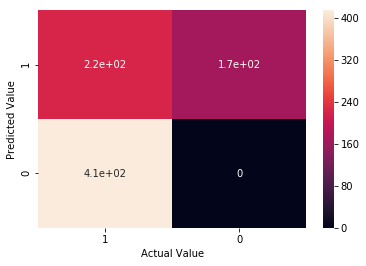

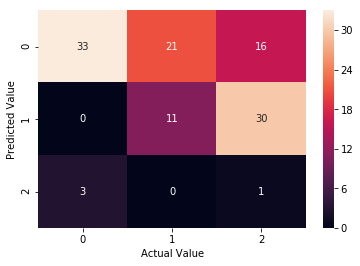

In [292]:
analyze_multiclass_metrics(train_features, train_multiclass_labels, test_features, test_multiclass_labels)